**Initial Setup**

In [1]:
!pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 20.8 MB/s eta 0:00:00


**Import Libraries**

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_model_optimization.sparsity import keras as sparsity
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.layers import Conv3D,Conv2D,Conv1D,MaxPooling1D, MaxPooling2D,TimeDistributed,LSTM,ConvLSTM2D, GRU
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.layers import TimeDistributed
import seaborn as sns
import h5py

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Load the WISDM dataset
data = pd.read_csv('/content/gdrive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None,delimiter=",", names=['user_id', 'activity', 'timestamp', 'x', 'y', 'z'])

# Data pre-processing

In [6]:
data.isnull().sum()

user_id      0
activity     0
timestamp    0
x            0
y            0
z            1
dtype: int64

In [7]:
data.dropna(axis=0, how='any', inplace= True)

In [8]:
data.isnull().sum()

user_id      0
activity     0
timestamp    0
x            0
y            0
z            0
dtype: int64

In [9]:
['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing']

['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

In [10]:
data['z'] = data['z'].str.replace(";","")
data['z'] = pd.to_numeric(data['z'])

In [11]:
data.head()

,user_id,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [12]:
def reset_label(dataCollection): 
    # Converting original labels {'Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'} to new labels, to store it in a .h5 file format
    mapping = {'Walking':0,'Jogging':1,'Upstairs':2,'Downstairs':3,'Sitting':4,'Standing':5} # old activity Id to new activity Id 
    for i in  ['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing']:
        dataCollection.loc[dataCollection.activity == i, 'activity'] = mapping[i]

    return dataCollection

In [13]:
dataset_reset=reset_label(data)

In [14]:
dataset_reset.head()

,user_id,activity,timestamp,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [15]:
def class_breakdown(data,col):
    # group data by the class value and calculate the number of rows
    counts = data.groupby(col).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(data) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [16]:
class_breakdown(dataset_reset,'activity')

Class=1, total=424397, percentage=38.645
Class=2, total=342176, percentage=31.158
Class=3, total=122869, percentage=11.188
Class=4, total=100427, percentage=9.145
Class=5, total=59939, percentage=5.458
Class=6, total=48395, percentage=4.407


In [17]:
X=dataset_reset.drop(['activity'],axis=1)
y=dataset_reset['activity']

#### code for remove class imbalance

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
def class_balance(X,y):
    oversample = SMOTE()
    y = LabelEncoder().fit_transform(y)
    X, y = oversample.fit_resample(X, y)
    return X,y

#### code for data segmentation into windows

In [ ]:
# ##code_1:
# def windows(data, size):
#     start = 0
#     while start < data.count():
#         yield int(start), int(start + size)
#         start += (size / 2)

# def segment_signal(data,window_size):
#     segments = np.empty((0,window_size,3))
#     labels = np.empty((0))
#     for (start, end) in windows(data["timestamp"], window_size):
#         x = data["x-axis"][start:end]
#         y = data["y-axis"][start:end]
#         z = data["z-axis"][start:end]
#         if(len(dataset["timestamp"][start:end]) == window_size and len(y)==window_size and len(x)==window_size and len(z)==window_size):
#             segments = np.vstack([segments,np.dstack([x,y,z])])
#             labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
#     return {'input' : np.asarray(segments), 'label': labels}

In [19]:
import scipy.stats as stats

In [20]:
# code_2
def segment_signal(data,window_size):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    start=0
    while start+window_size < data.shape[0]:
        end=start + window_size
        x = data["x"][start:end]
        y = data["y"][start:end]
        z = data["z"][start:end]
        # if(len(dataset["timestamp"][start:end]) == window_size and len(y)==window_size and len(x)==window_size and len(z)==window_size):
        segments = np.vstack([segments,np.dstack([x,y,z])])
        labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
        start+=int(window_size/2)
    return {'input' : np.asarray(segments), 'label': labels}

In [21]:
#SEGMENT DATA, LABELS INTO WINDOW_SIZE
window_size=128

### save the data in h5 format


In [22]:
def save_data(data,file_name): 
    f = h5py.File(file_name,'w')
    for key in data:
        print(key)
        f.create_dataset(key,data = data[key])       
    f.close()
    print('Done.')    

### sample the whole data first, then segmented & saved:

In [23]:
#data sampled
X_sampled,y_sampled=class_balance(X,y)

In [24]:
data_sampled=pd.concat([pd.DataFrame(X_sampled),pd.DataFrame(y_sampled,columns = ['activity'])],axis=1)

In [25]:
class_breakdown(data_sampled,'activity')

Class=1, total=424397, percentage=16.667
Class=2, total=424397, percentage=16.667
Class=3, total=424397, percentage=16.667
Class=4, total=424397, percentage=16.667
Class=5, total=424397, percentage=16.667
Class=6, total=424397, percentage=16.667


In [26]:
# data segmented
data_segmented=segment_signal(data_sampled,window_size)

In [27]:
file="wisdm_sampled_segmented.h5"
save_data(data_segmented,file)

input
label
Done.


# Splitting the data into training, testing and validation

In [28]:
path="/content/wisdm_sampled_segmented.h5"

In [29]:
f = h5py.File(path, 'r')
X = f.get('input')
y = f.get('label') 
X = np.array(X)
y = np.array(y)

In [30]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state = 1)
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.3, random_state = 1)

In [31]:
X_train.shape

(19495, 128, 3)

In [32]:
X_val.shape

(8355, 128, 3)

In [33]:
y_train.shape

(19495,)

In [34]:
y_val.shape

(8355,)

In [35]:
from keras.utils import to_categorical
trainy_one_hot = to_categorical(y_train)
testy_one_hot = to_categorical(y_test)

In [36]:
y_val_hot = to_categorical(y_val)

In [37]:
y_val_hot.shape

(8355, 6)

In [38]:
X_val.shape

(8355, 128, 3)

In [39]:
X_train.shape, X_test.shape

((19495, 128, 3), (11936, 128, 3))

In [40]:
y_train.shape, y_test.shape

((19495,), (11936,))

In [41]:
trainy_one_hot.shape, testy_one_hot.shape

((19495, 6), (11936, 6))

In [42]:
testy_one_hot

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [43]:
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [44]:
class_breakdown(y_train)

Class=1, total=3202, percentage=16.425
Class=2, total=3256, percentage=16.702
Class=3, total=3191, percentage=16.368
Class=4, total=3258, percentage=16.712
Class=5, total=3290, percentage=16.876
Class=6, total=3298, percentage=16.917


In [45]:
class_breakdown(y_test)

Class=1, total=1962, percentage=16.438
Class=2, total=2004, percentage=16.790
Class=3, total=2063, percentage=17.284
Class=4, total=1978, percentage=16.572
Class=5, total=1955, percentage=16.379
Class=6, total=1974, percentage=16.538


In [46]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], trainy_one_hot.shape[1]

In [ ]:
n_timesteps, n_features, n_outputs

(128, 3, 6)

# Build and train the model

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GRU(units=64, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_outputs, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           640       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 64)           0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 25,990
Trainable params: 25,990
Non-trainable params: 0
____________________________________________________

In [ ]:
#to_categorical(y_val)

In [48]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
history = model.fit(X_train, trainy_one_hot, validation_data=(X_val, y_val_hot), epochs=10, batch_size=32)

Epoch 1/10
610/610 [==============================] - 6s 11ms/step - loss: 0.0536 - accuracy: 0.9814 - val_loss: 0.0767 - val_accuracy: 0.9735
Epoch 2/10
610/610 [==============================] - 5s 8ms/step - loss: 0.0493 - accuracy: 0.9826 - val_loss: 0.1048 - val_accuracy: 0.9676
Epoch 3/10
610/610 [==============================] - 4s 7ms/step - loss: 0.0511 - accuracy: 0.9835 - val_loss: 0.0771 - val_accuracy: 0.9727
Epoch 4/10
610/610 [==============================] - 6s 9ms/step - loss: 0.0491 - accuracy: 0.9836 - val_loss: 0.1703 - val_accuracy: 0.9443
Epoch 5/10
610/610 [==============================] - 4s 7ms/step - loss: 0.0422 - accuracy: 0.9865 - val_loss: 0.0760 - val_accuracy: 0.9750
Epoch 6/10
610/610 [==============================] - 4s 7ms/step - loss: 0.0500 - accuracy: 0.9834 - val_loss: 0.0829 - val_accuracy: 0.9730
Epoch 7/10
610/610 [==============================] - 5s 8ms/step - loss: 0.0317 - accuracy: 0.9900 - val_loss: 0.0731 - val_accuracy: 0.9765
Epoch

In [ ]:
test_loss, test_acc = model.evaluate(X_val, y_val_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

262/262 [==============================] - 3s 11ms/step - loss: 0.0841 - accuracy: 0.9701
Test loss: 0.08409694582223892
Test accuracy: 0.9700778126716614


**Visualization of Training and Validation loss**

In [ ]:
import matplotlib.pyplot as plt

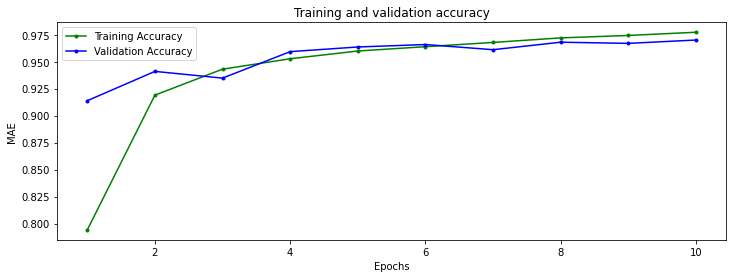

In [ ]:
# graph of mean absolute error
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs, mae, 'g.', linestyle='solid', label='Training Accuracy')
plt.plot(epochs, val_mae, 'b.', linestyle='solid', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

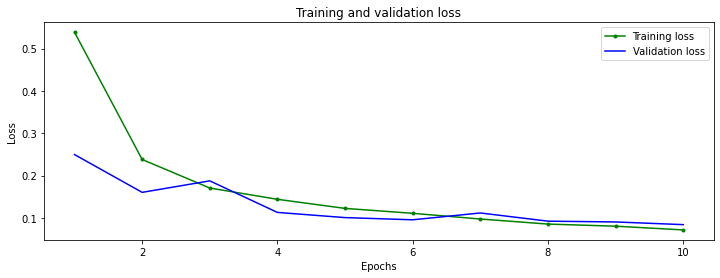

[12.0, 4.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (12,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, 'b', linestyle='solid', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

**Confusion Matrix**

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(X_val)

262/262 [==============================] - 3s 11ms/step


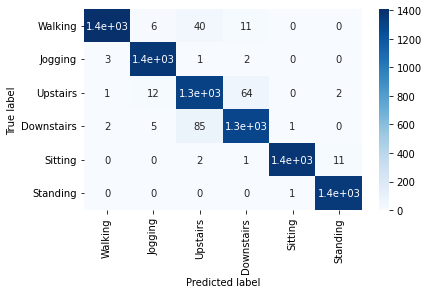

In [ ]:
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_hot, 1), predictions=tf.argmax(predictions, 1))
axis_labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
figure = plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.ylim(len(cm)-0, 0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
model.save('model.h5')

# Conversion of model to tensorflow lite model

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("model.tflite")
print("Model is %d bytes" % basic_model_size)

Model is 117208 bytes


# Creating Model Header File

In [ ]:
# Compile the TensorFlow Lite model into a C source file
!xxd -i model.tflite > model.cc

# Create a header file from the C source file
!sed 's/unsigned/const unsigned/g' model.cc > model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 722,871 bytes.


# Pruning the model and Fit the pruning model

In [ ]:
import tensorflow_model_optimization as tfmot

pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=1000
)

pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)
pruned_model.summary()

import tempfile

logdir = tempfile.mkdtemp()

callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',min_lr=0.0001)

]
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
his = pruned_model.fit(X_train, trainy_one_hot, epochs = 10, batch_size=32, callbacks=callbacks, validation_data= (X_val, y_val_hot), verbose=1)


score = pruned_model.evaluate(X_val, y_val_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv1d_  (None, 126, 64)          1218      
 4 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 63, 64)           1         
 ling1d_4 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_gru_4 (  (None, 64)               49539     
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_dropout  (None, 64)               1         
 _4 (PruneLowMagnitude)                                          
                                                      

In [ ]:
score = pruned_model.evaluate(X_val, y_val_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08614905178546906
Test accuracy: 0.9745062589645386


**Strip the pruning model**

In [ ]:
pruned_model = sparsity.strip_pruning(pruned_model)
pruned_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 126, 64)           640       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 gru_4 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 25,990
Trainable params: 25,990
Non-trainable params: 0
__________________________________________________

In [ ]:
pruned_model.compile(
    loss=["mse"],
    optimizer="adam",
    metrics=['accuracy']
)


**Confusion matrix of pruned model**

262/262 [==============================] - 3s 11ms/step


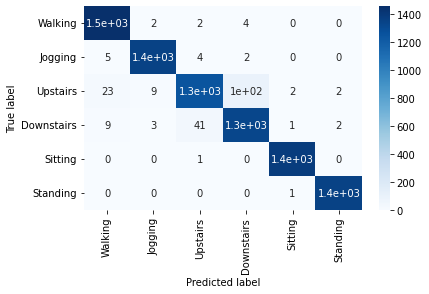

In [ ]:
predictions_p = pruned_model.predict(X_val)
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_hot, 1), predictions=tf.argmax(predictions_p, 1))
axis_labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
figure = plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.tight_layout()
plt.ylim(len(cm)-0, 0)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Weights of pruned model

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

for i, w in enumerate(pruned_model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            pruned_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

conv1d_4/kernel:0 -- Total:576, Zeros: 50.00%
conv1d_4/bias:0 -- Total:64, Zeros: 0.00%
gru_4/gru_cell_8/kernel:0 -- Total:12288, Zeros: 50.00%
gru_4/gru_cell_8/recurrent_kernel:0 -- Total:12288, Zeros: 50.00%
gru_4/gru_cell_8/bias:0 -- Total:384, Zeros: 0.00%
dense_4/kernel:0 -- Total:384, Zeros: 50.00%
dense_4/bias:0 -- Total:6, Zeros: 0.00%


# Converting pruned model to tflite model

In [ ]:
# Convert pruned model to TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_lower_tensor_list_ops = False
tflite_pruned_model = converter.convert()

# Save the TFLite model to disk
with open('pruned_model.tflite', 'wb') as f:
    f.write(tflite_pruned_model)

# Print size of TFLite model
pruned_model_size = os.path.getsize("pruned_model.tflite")
print("Pruned model size: %d bytes" % pruned_model_size)

Pruned model size: 43600 bytes


# Creating Pruned Model Header File

In [ ]:
# Compile the TensorFlow Lite model into a C source file
!xxd -i pruned_model.tflite > Pmodel.cc

# Create a header file from the C source file
!sed 's/unsigned/const unsigned/g' Pmodel.cc > Pmodel.h

import os
Pmodel_h_size = os.path.getsize("Pmodel.h")
print(f"Header file, Pmodel.h, is {Pmodel_h_size:,} bytes.")

Header file, Pmodel.h, is 268,968 bytes.


In [ ]:
pruned_model.save('pruned_model.h5')

# Quantization of pruned model

In [ ]:
# Define a function to generate representative data for quantization
def representative_data_gen():
  for input_value in np.array(X_train, dtype=np.float32):
    yield [np.expand_dims(input_value, axis=0)]



# Convert the Keras model to a TensorFlow Lite model with quantization
pruned_model = tf.keras.models.load_model('pruned_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
pruned_quantized_tflite_model = converter.convert()

# Save the quantized model to disk
with open("pruned_quantized_model.tflite", "wb") as f:
    f.write(pruned_quantized_tflite_model)

# Check the size of the quantized model
quantized_model_size = os.path.getsize("pruned_quantized_model.tflite")
print("pruned_quantized_model is %d bytes" % quantized_model_size)

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


pruned_quantized_model is 43376 bytes


# Creating Quantized Model Header File

In [ ]:
# Compile the TensorFlow Lite model into a C source file
!xxd -i pruned_quantized_model.tflite > Pqmodel.cc

# Create a header file from the C source file
!sed 's/unsigned/const unsigned/g' Pqmodel.cc > Pqmodel.h

import os
Pqmodel_h_size = os.path.getsize("Pqmodel.h")
print(f"Header file, Pqmodel.h, is {Pqmodel_h_size:,} bytes.")

Header file, Pqmodel.h, is 267,606 bytes.


# Evaluating the Quantized Model

In [ ]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  arr = []
  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(X_val):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    # print(test_image)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)

  for i in range(0,len(y_val_hot)):
    arr.append(np.argmax(y_val_hot[i]))
  accuracy = (prediction_digits == np.array(arr)).mean()
  return accuracy

In [ ]:
# Pruned and Quantized model accuracy
interpreter = tf.lite.Interpreter(model_content=pruned_quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)

Pruned and quantized TFLite test_accuracy: 0.9752244165170556


In [ ]:
# Pruned model accuracy
interpreter1 = tf.lite.Interpreter(model_content=tflite_pruned_model)
interpreter1.allocate_tensors()

test_accuracy_ = evaluate_model(interpreter1)
print('Pruned TF test accuracy:', test_accuracy_)

Pruned TF test accuracy: 0.9740275284260922
